# Data Processing

This codes replicates the method of data processing agent of the original paper "A Multi-Agent Approach for Personalised Hypertension Risk Prediction"

In [2]:
# Library used
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
from scipy.stats import norm
import matplotlib.pyplot as plt

## Preprocessing
This comprises estimating missing data entries and removal of outliers
In the general population, blood pressure is known to exhibit a Gassian (normal) distribution pattern which makes Gaussian mixture models a suitable candidate for modelling blood pressure behaviour. For this study, we compute the missing records in the blood pressure historical data using Gaussian mixture regression (GMR) and identify outliers using Gaussian mixture models (GMM)
### Missing Data Estimation
This task is of utmost importance because most of the learning algorithms expect a continous time series to make accurate predictions, and the presence of missing values reduces the accuracy in the results
#### Identification of missing values
This is achieved by iterating through the received time series and comparing the timestamps associated with each record. Upon encountering non-consecutive time stamps, missing data and the intermediate data records are inserted into the time series with some initial value (Algorithm 1)

In [3]:
# Load and sort the data
data = pd.read_csv("C:/Users/m/OneDrive - The University of Melbourne/Documents/Learning/Research/WearableData/Mappings - All Data.csv")
print(data.shape)
print(data.head())

(18842, 9)
   UserID  Systolic  Diastolic  Heart Rate            Timestamp         DOB  \
0    9690     125.0       87.0        98.0  2018-05-16 11:00:00  1973-05-08   
1    9690     121.0       84.0        39.5  2018-05-16 12:00:00  1973-05-08   
2    9690     122.5       84.0        44.5  2018-05-16 13:00:00  1973-05-08   
3    9690     123.0       80.0        80.0  2018-05-16 14:00:00  1973-05-08   
4    9690     125.0       78.0        72.0  2018-05-16 15:00:00  1973-05-08   

   Weight  Height Gender  
0    96.0     177      M  
1    96.0     177      M  
2    96.0     177      M  
3    96.0     177      M  
4    96.0     177      M  


In [4]:
data["Timestamp"] = pd.to_datetime(data["Timestamp"]) #ensure timestamp is datetime
data = data.sort_values(by = ["UserID", "Timestamp"]).reset_index(drop = True)

# expected time interval is hourly
EXPECTED_INTERVAL = pd.Timedelta(hours = 1)

In [5]:
# Identify missing timestamps
missing_rows = []
for user_id, user_df  in data.groupby("UserID"):
    user_df = user_df.sort_values("Timestamp").reset_index(drop = True)
    for i in range(1, len(user_df)):
        current_time = user_df.loc[i, "Timestamp"]
        previous_time = user_df.loc[i - 1, "Timestamp"]
        time_diff = current_time - previous_time

        # If gap is larger than expected, it's missing data
        if time_diff > EXPECTED_INTERVAL:
            num_missing = int(time_diff/ EXPECTED_INTERVAL) - 1
            for j in range(1, num_missing + 1):
                 missing_time = previous_time + j * EXPECTED_INTERVAL
                 missing_rows.append({
                 "UserID": user_id,
                 "Timestamp": missing_time,
                 "Systolic": None,
                 "Diastolic": None,
                 "Heart Rate": None,
                 "IsMissing": True #create a dummy variable
                 })

#### Estimate values for the missing records using Gaussian mixture regression
We use Gaussian mixture regression to estimate the missing heart rate, systolic, and diastolic blood pressure values. A Gaussian distribution is modelled using the input data. A Gaussian mixture comprises several Gaussians, with each containing: a mean that defines the centre of the distribution and covariance that represents its width and weight that determines the size of the Gaussian function. (Algorithm 2)
The paper chooses GMR over simpler interpolation because biological signals like blood pressure are non-linear and multimodal. A patient might have stable periods and volatile periods; GMR can learn these distinct behaviours as separate Gaussian components, whereas a simple average would blur them together, loosing variance information.

In [6]:
# Insert missing records into the dataset
missing_df = pd.DataFrame(missing_rows)

# Mark existing data as non-missing
data["IsMissing"] = False

# Combine original and missing datasets
data_complete = pd.concat([data, missing_df], ignore_index = True)
data_complete = data_complete.sort_values(by = ["UserID", "Timestamp"]).reset_index(drop = True)
STATIC_COLS = ["DOB", "Weight", "Height", "Gender"] # those variables don't change over time
data_complete[STATIC_COLS] = (data_complete.groupby("UserID")[STATIC_COLS].transform(lambda x: x.ffill().bfill()))

C:\Users\m\AppData\Local\Temp\ipykernel_23456\2793902377.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_complete = pd.concat([data, missing_df], ignore_index = True)


In [7]:
data_complete.head(15)

,UserID,Systolic,Diastolic,Heart Rate,Timestamp,DOB,Weight,Height,Gender,IsMissing
0,9630,125.0,86.0,40.5,2018-04-23 13:00:00,1963-07-06,83.0,172.0,M,False
1,9630,125.5,84.0,46.0,2018-04-23 14:00:00,1963-07-06,83.0,172.0,M,False
2,9630,126.0,87.0,0.0,2018-04-23 15:00:00,1963-07-06,83.0,172.0,M,False
3,9630,123.0,86.5,54.5,2018-04-23 16:00:00,1963-07-06,83.0,172.0,M,False
4,9630,124.0,82.0,82.0,2018-04-23 17:00:00,1963-07-06,83.0,172.0,M,False
5,9630,108.4,73.4,0.0,2018-04-23 18:00:00,1963-07-06,83.0,172.0,M,False
6,9630,NaN,NaN,NaN,2018-04-23 19:00:00,1963-07-06,83.0,172.0,M,True
7,9630,NaN,NaN,NaN,2018-04-23 20:00:00,1963-07-06,83.0,172.0,M,True
8,9630,NaN,NaN,NaN,2018-04-23 21:00:00,1963-07-06,83.0,172.0,M,True
9,9630,NaN,NaN,NaN,2018-04-23 22:00:00,1963-07-06,83.0,172.0,M,True


In [8]:
data["UserID"].unique()

array([ 9630,  9690,  9888, 10049, 10412])

In [9]:
print(len(data_complete[data_complete["UserID"] == 10412]))
print(len(data_complete[data_complete["UserID"] == 10049]))
print(len(data_complete[data_complete["UserID"] == 9690]))
print(len(data_complete[data_complete["UserID"] == 9888]))
print(len(data_complete[data_complete["UserID"] == 9630]))

6059
7322
6046
5581
5804


In [10]:
# Check for user 9630
start_date = data[data["UserID"] == 9630]["Timestamp"].min()
end_date = data[data["UserID"] == 9630]["Timestamp"].max()
print(start_date)
print(end_date)
difference = end_date - start_date
total_hours = difference.total_seconds()/3600
print(f"Time difference: {difference}")
print(f"Total Hours: {total_hours}")
print(f"Total measurement: {total_hours + 1}")

# This indicates it should have 5803 entries

2018-04-23 13:00:00
2018-12-21 08:00:00
Time difference: 241 days 19:00:00
Total Hours: 5803.0
Total measurement: 5804.0


In [13]:
print(data_complete[data_complete["UserID"] == 9630])
data_complete.to_csv("complete_dataset.csv", index=False)

      UserID  Systolic  Diastolic  Heart Rate           Timestamp         DOB  \
0       9630     125.0       86.0        40.5 2018-04-23 13:00:00  1963-07-06   
1       9630     125.5       84.0        46.0 2018-04-23 14:00:00  1963-07-06   
2       9630     126.0       87.0         0.0 2018-04-23 15:00:00  1963-07-06   
3       9630     123.0       86.5        54.5 2018-04-23 16:00:00  1963-07-06   
4       9630     124.0       82.0        82.0 2018-04-23 17:00:00  1963-07-06   
...      ...       ...        ...         ...                 ...         ...   
5799    9630     126.0       78.0        75.0 2018-12-21 04:00:00  1963-07-06   
5800    9630     123.0       80.0        78.0 2018-12-21 05:00:00  1963-07-06   
5801    9630     120.0       79.0        78.0 2018-12-21 06:00:00  1963-07-06   
5802    9630     126.0       78.0        74.0 2018-12-21 07:00:00  1963-07-06   
5803    9630     118.0       79.0        75.0 2018-12-21 08:00:00  1963-07-06   

      Weight  Height Gender

In [11]:
data.isna().sum()

UserID        0
Systolic      0
Diastolic     0
Heart Rate    0
Timestamp     0
DOB           0
Weight        0
Height        0
Gender        0
IsMissing     0
dtype: int64

In [12]:
df = data.copy()

# Timestamp → hour, day
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df["Hour"] = df["Timestamp"].dt.hour
df["DayOfWeek"] = df["Timestamp"].dt.dayofweek

# Age from DOB
df["DOB"] = pd.to_datetime(df["DOB"])
df["Age"] = (df["Timestamp"] - df["DOB"]).dt.days / 365

# Encode Gender
df["GenderEncoded"] = df["Gender"].map({"M": 0, "F": 1})

In [13]:
Y_cols = ["Systolic", "Diastolic", "Heart Rate"]
X_cols = ["Hour", "DayOfWeek", "Age", "Weight", "Height", "GenderEncoded"]

In [14]:
X_train = df[X_cols + Y_cols].values

bic_scores = []
K_range = range(1, 20)

for k in K_range:
    gmm = GaussianMixture(
        n_components=k,
        covariance_type="full",
        random_state=42
    )
    gmm.fit(X_train)
    bic_scores.append(gmm.bic(X_train))

best_k = K_range[np.argmin(bic_scores)]
print("Best K =", best_k)

gmm = GaussianMixture(
    n_components=best_k,
    covariance_type="full",
    random_state=42
)
gmm.fit(X_train)

Best K = 19


GaussianMixture(n_components=19, random_state=42)

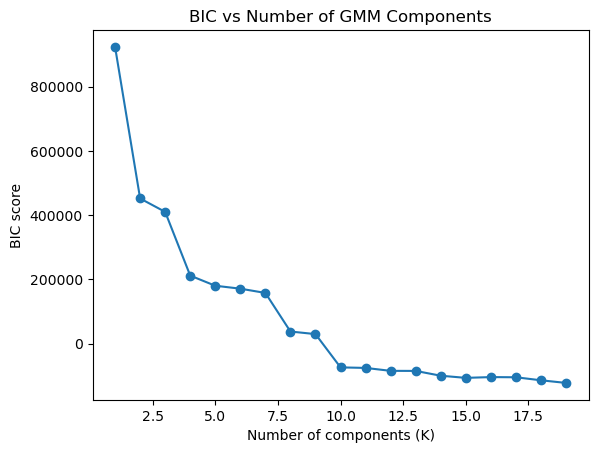

In [15]:
# ===== Plot =====
plt.figure()
plt.plot(K_range, bic_scores, marker='o')
plt.xlabel("Number of components (K)")
plt.ylabel("BIC score")
plt.title("BIC vs Number of GMM Components")
plt.show()

In [16]:
gmm = GaussianMixture(
        n_components=best_k,
        covariance_type="full",
        random_state=42
    )
gmm.fit(X_train)

GaussianMixture(n_components=19, random_state=42)

In [17]:
def multivariate_gaussian(x, mean, cov):
    d = len(mean)
    cov_inv = np.linalg.pinv(cov)
    diff = x - mean
    exponent = -0.5 * diff @ cov_inv @ diff.T
    denom = np.sqrt((2 * np.pi) ** d * np.linalg.det(cov) + 1e-9)
    return np.exp(exponent) / denom

In [18]:
def gmr_impute(row, gmm, X_cols, Y_cols):
    """ This function implements Gaussian Mixture Regression (GMR) for imputing missing values
     - Row: A data row containing observed values
     - X_cols: Column names of observed variables
     - Y_cols: Column names of variable to be imputed """
    x = row[X_cols].values.reshape(1, -1)

    d_x = len(X_cols)
    means = gmm.means_
    covs = gmm.covariances_
    weights = gmm.weights_

    y_preds = []
    responsibilities = []

    for k in range(gmm.n_components):
        mu_x = means[k][:d_x]
        mu_y = means[k][d_x:]

        sigma_xx = covs[k][:d_x, :d_x]
        sigma_yx = covs[k][d_x:, :d_x]

        sigma_xx_inv = np.linalg.pinv(sigma_xx)
        y_k = mu_y + sigma_yx @ sigma_xx_inv @ (x - mu_x).T

        y_preds.append(y_k.flatten())

        resp = weights[k] * multivariate_gaussian(
            x.flatten(), mu_x, sigma_xx
        )
        responsibilities.append(resp)

    responsibilities = np.array(responsibilities)
    responsibilities /= responsibilities.sum()

    y_hat = np.sum(
        responsibilities[:, None] * np.array(y_preds),
        axis=0
    )

    return y_hat.flatten()


In [19]:
df_filled = data_complete.copy()

# Timestamp → hour, day
df_filled["Timestamp"] = pd.to_datetime(df_filled["Timestamp"])
df_filled["Hour"] = df_filled["Timestamp"].dt.hour
df_filled["DayOfWeek"] = df_filled["Timestamp"].dt.dayofweek

# Age from DOB
df_filled["DOB"] = pd.to_datetime(df_filled["DOB"])
df_filled["Age"] = (df_filled["Timestamp"] - df_filled["DOB"]).dt.days / 365

# Encode Gender
df_filled["GenderEncoded"] = df_filled["Gender"].map({"M": 0, "F": 1})

missing_mask = df_filled["IsMissing"] == True

for idx, row in df_filled[missing_mask].iterrows():
    y_hat = gmr_impute(row, gmm, X_cols, Y_cols)
    df_filled.loc[idx, Y_cols] = y_hat[-3:]

In [20]:
df_filled.head(20)

,UserID,Systolic,Diastolic,Heart Rate,Timestamp,DOB,Weight,Height,Gender,IsMissing,Hour,DayOfWeek,Age,GenderEncoded
0,9630,125.000000,86.000000,40.500000,2018-04-23 13:00:00,1963-07-06,83.0,172.0,M,False,13,0,54.835616,0
1,9630,125.500000,84.000000,46.000000,2018-04-23 14:00:00,1963-07-06,83.0,172.0,M,False,14,0,54.835616,0
2,9630,126.000000,87.000000,0.000000,2018-04-23 15:00:00,1963-07-06,83.0,172.0,M,False,15,0,54.835616,0
3,9630,123.000000,86.500000,54.500000,2018-04-23 16:00:00,1963-07-06,83.0,172.0,M,False,16,0,54.835616,0
4,9630,124.000000,82.000000,82.000000,2018-04-23 17:00:00,1963-07-06,83.0,172.0,M,False,17,0,54.835616,0
5,9630,108.400000,73.400000,0.000000,2018-04-23 18:00:00,1963-07-06,83.0,172.0,M,False,18,0,54.835616,0
6,9630,119.750407,81.553982,82.205720,2018-04-23 19:00:00,1963-07-06,83.0,172.0,M,True,19,0,54.835616,0
7,9630,119.732295,81.399782,82.385918,2018-04-23 20:00:00,1963-07-06,83.0,172.0,M,True,20,0,54.835616,0
8,9630,119.717048,81.249570,82.448080,2018-04-23 21:00:00,1963-07-06,83.0,172.0,M,True,21,0,54.835616,0
9,9630,119.711623,81.111115,82.406538,2018-04-23 22:00:00,1963-07-06,83.0,172.0,M,True,22,0,54.835616,0


In [27]:
df_filled.to_csv("dataset_after_gmr_imputation.csv", index=False)

In [26]:
systolic_9630_filled = df_filled.loc[df_filled["UserID"] == 9630].sort_values("Timestamp")["Systolic"].astype(float)
systolic_9630_ori = data_complete.loc[data_complete["UserID"] == 9630].sort_values("Timestamp")["Systolic"].astype(float)

In [27]:
print(systolic_9630_filled.head(50))
print(systolic_9630_ori.head(50))


0     125.000000
1     125.500000
2     126.000000
3     123.000000
4     124.000000
5     108.400000
6     119.750407
7     119.732295
8     119.717048
9     119.711623
10    119.718543
11    118.707836
12    118.746472
13    118.779605
14    118.805703
15    118.824361
16    118.837388
17    118.849680
18     97.000000
19    120.000000
20    123.000000
21    119.000000
22    126.000000
23    125.000000
24    125.500000
25    124.000000
26    117.666700
27    127.000000
28    124.000000
29    123.500000
30    119.906545
31    119.888441
32    119.868750
33    119.855542
34    119.852774
35    119.036996
36    119.069005
37    119.096703
38    119.118532
39    119.133549
40    119.142332
41    119.147911
42    124.500000
43    112.000000
44    118.000000
45    122.500000
46    123.000000
47    105.000000
48    120.000000
49    122.000000
Name: Systolic, dtype: float64
0     125.0000
1     125.5000
2     126.0000
3     123.0000
4     124.0000
5     108.4000
6          NaN
7          NaN

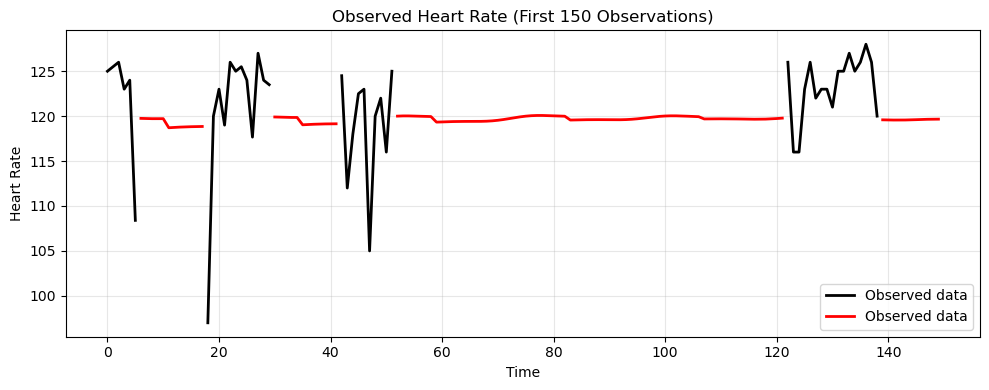

In [31]:
plt.figure(figsize=(10, 4))
plt.plot(
    systolic_9630_ori.index[:150],
    systolic_9630_ori.values[:150],
    color="black",
    linewidth=2,
    label="Observed data"
)

imputed_only = systolic_9630_filled.copy()
imputed_only[~systolic_9630_ori.isna()] = np.nan
plt.plot(
    imputed_only.index[:150],
    imputed_only.values[:150],
    color="red",
    linewidth=2,
    label="Observed data"
)

plt.xlabel("Time")
plt.ylabel("Heart Rate")
plt.title("Observed Heart Rate (First 150 Observations)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
